# Tools and Toolchains

This notebook demonstrates using tools and toolchains when ordering with the orders api. Specifically, this notebook demonstrates the following toolchains:
 - `clip`
 - `bandmath`
 - `toar`
 - `clip` -> `bandmath`
 - `toar` -> `reproject` -> `tile`

For background on ordering and downloading with the orders api, see the [Ordering and Delivery](ordering_and_delivery.ipynb) notebook.

Reference information can be found at [Tools & toolchains](https://developers.planet.com/docs/orders/tools-toolchains/).

## Setup

In [1]:
import json
import os
import pathlib
import time

import numpy as np
import rasterio
from rasterio.plot import show
import requests
from requests.auth import HTTPBasicAuth

In [2]:
# API Key stored as an env variable
PLANET_API_KEY = os.getenv('PL_API_KEY')

orders_url = 'https://api.planet.com/compute/ops/orders/v2'

# set up requests to work with api
auth = HTTPBasicAuth(PLANET_API_KEY, '')
headers = {'content-type': 'application/json'}

In [5]:
# define products part of order
products = [
    {
      "item_ids": ["20151119_025740_0c74"],
      "item_type": "PSScene4Band",
      "product_bundle": "analytic"
    }
]

In [122]:
# define helpful functions for submitting, polling, and downloading an order
def place_order(request, auth):
    response = requests.post(orders_url, data=json.dumps(request), auth=auth, headers=headers)
    print(response)
    
    if not response.ok:
        raise Exception(response.content)

    order_id = response.json()['id']
    print(order_id)
    order_url = orders_url + '/' + order_id
    return order_url

def poll_for_success(order_url, auth, num_loops=50):
    count = 0
    while(count < num_loops):
        count += 1
        r = requests.get(order_url, auth=auth)
        response = r.json()
        state = response['state']
        print(state)
        end_states = ['success', 'failed', 'partial']
        if state in end_states:
            break
        time.sleep(10)
        
def download_order(order_url, auth, overwrite=False):
    r = requests.get(order_url, auth=auth)
    print(r)

    response = r.json()
    results = response['_links']['results']
    results_urls = [r['location'] for r in results]
    results_names = [r['name'] for r in results]
    results_paths = [pathlib.Path(os.path.join('data', n)) for n in results_names]
    print('{} items to download'.format(len(results_urls)))
    
    for url, name, path in zip(results_urls, results_names, results_paths):
        if overwrite or not path.exists():
            print('downloading {} to {}'.format(name, path))
            r = requests.get(url, allow_redirects=True)
            path.parent.mkdir(parents=True, exist_ok=True)
            open(path, 'wb').write(r.content)
        else:
            print('{} already exists, skipping {}'.format(path, name))
            
    return dict(zip(results_names, results_paths))

In [123]:
# define helpful functions for visualizing downloaded imagery
def show_rgb(img_file):
    with rasterio.open(img_file) as src:
        b,g,r,n = src.read()

    rgb = np.stack((r,g,b), axis=0)
    show(rgb/rgb.max())
    
def show_gray(img_file):
    with rasterio.open(img_file) as src:
        g = src.read(1)
    show(g/g.max())

## Tool Demos

### No Processing (reference)

We will order and download the unprocessed image for comparison with the output of the toolchains defined below.

In [30]:
request = {
  "name": "no processing",
  "products": products,
}

In [39]:
# allow for caching, replace this with your image file
img_file = 'data/50df6201-ea94-48f1-bec9-65dd9cd8354b/1/files/PSScene4Band/20151119_025740_0c74/analytic/20151119_025740_0c74_3B_AnalyticMS.tif'
img_file

'data/50df6201-ea94-48f1-bec9-65dd9cd8354b/1/files/PSScene4Band/20151119_025740_0c74/analytic/20151119_025740_0c74_3B_AnalyticMS.tif'

In [40]:
if not os.path.isfile(img_file):
    order_url = place_order(request, auth)
    poll_for_success(order_url, auth)
    downloaded_files = download_order(order_url, auth)
    img_file = next(downloaded_files[d] for d in downloaded_files
                    if d.endswith('_3B_AnalyticMS.tif'))
print(img_file)

data/50df6201-ea94-48f1-bec9-65dd9cd8354b/1/files/PSScene4Band/20151119_025740_0c74/analytic/20151119_025740_0c74_3B_AnalyticMS.tif


### Clip

Clipping is likely the most common tool that will be used. It allows us to only download the pixels we are interested in.

In [41]:
clip_aoi = {
    "type":"Polygon",
    "coordinates":[[[94.81858044862747,15.858073043526062],
                    [94.86242249608041,15.858073043526062],
                    [94.86242249608041,15.894323164978303],
                    [94.81858044862747,15.894323164978303],
                    [94.81858044862747,15.858073043526062]]]
}

In [124]:
# define the clip tool
clip = {
    "clip": {
        "aoi": clip_aoi
    }
}

In [73]:
# create an order request with the clipping tool
request_clip = {
  "name": "just clip",
  "products": products,
  "tools": [clip]
}

request_clip

{'name': 'just clip',
 'products': [{'item_ids': ['20151119_025740_0c74'],
   'item_type': 'PSScene4Band',
   'product_bundle': 'analytic'}],
 'tools': [{'clip': {'aoi': {'coordinates': [[[94.81858044862747,
        15.858073043526062],
       [94.86242249608041, 15.858073043526062],
       [94.86242249608041, 15.894323164978303],
       [94.81858044862747, 15.894323164978303],
       [94.81858044862747, 15.858073043526062]]],
     'type': 'Polygon'}}}]}

In [56]:
# allow for caching so we don't always run clip
run_clip = True

clip_img_file = 'data/6c23f9e1-d86a-47fe-9eb2-2693196168e0/1/files/20151119_025740_0c74_3B_AnalyticMS_clip.tif'
if os.path.isfile(clip_img_file): run_clip = False

In [85]:
if run_clip:
    clip_order_url = place_order(request_clip, auth)
    poll_for_success(clip_order_url, auth)
    downloaded_clip_files = download_order(clip_order_url, auth)
    clip_img_file = next(downloaded_clip_files[d] for d in downloaded_clip_files
                     if d.endswith('_3B_AnalyticMS_clip.tif'))
clip_img_file

'data/6c23f9e1-d86a-47fe-9eb2-2693196168e0/1/files/20151119_025740_0c74_3B_AnalyticMS_clip.tif'

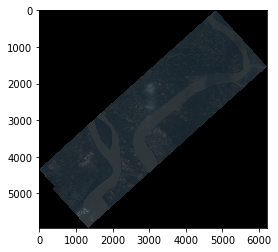

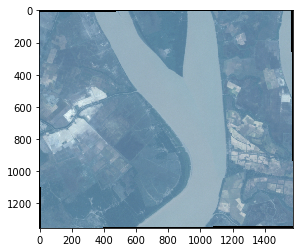

In [61]:
show_rgb(img_file)
show_rgb(clip_img_file)

Alright! Clipping worked. Beautiful! This saves a lot of download bandwidth and processing on our end.

### Band Math

To demonstrate band math we will order an NDVI image.

In [7]:
bandmath = {
  "bandmath": {
    "pixel_type": "32R",
    "b1": "(b4 - b3) / (b4 + b3)"
  }
}

In [8]:
bandmath_request = {
  "name": "band math",
  "products": products,
  "tools": [bandmath]
}
bandmath_request

{'name': 'band math',
 'products': [{'item_ids': ['20151119_025740_0c74'],
   'item_type': 'PSScene4Band',
   'product_bundle': 'analytic'}],
 'tools': [{'bandmath': {'b1': '(b4 - b3) / (b4 + b3)', 'pixel_type': '32R'}}]}

In [63]:
run_bandmath = True

# allow for caching so we don't always run clip
bandmath_img_file = 'data/06a733ff-3034-4ffe-b1c4-8f5d004feaff/1/files/20151119_025740_0c74_3B_AnalyticMS_bandmath.tif'
if os.path.isfile(bandmath_img_file): run_bandmath = False

In [76]:
if run_bandmath:
    bandmath_order_url = place_order(bandmath_request, auth)
    poll_for_success(bandmath_order_url, auth)
    downloaded_bandmath_files = download_order(bandmath_order_url, auth)
    bandmath_file = next(downloaded_bandmath_files[d] for d in downloaded_bandmath_files
                     if d.endswith('_bandmath.tif'))
bandmath_file

PosixPath('data/06a733ff-3034-4ffe-b1c4-8f5d004feaff/1/files/20151119_025740_0c74_3B_AnalyticMS_bandmath.tif')

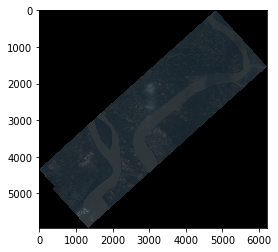

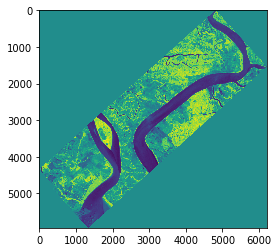

In [67]:
show_rgb(img_file)
show_gray(bandmath_file)

This is a beautiful NDVI image!

### TOAR

The `toar` tool converts imagery to Top of Atmosphere Reflectance.

In [14]:
toar = {
      "toar": {
        "scale_factor": 10000
      }
}
toar_request = {
  "name": "toar",
  "products": products,
  "tools": [toar]
}
toar_request

{'name': 'toar',
 'products': [{'item_ids': ['20151119_025740_0c74'],
   'item_type': 'PSScene4Band',
   'product_bundle': 'analytic'}],
 'tools': [{'toar': {'scale_factor': 10000}}]}

In [69]:
run_toar = True

# allow for caching so we don't always run clip
toar_img_file = 'data/d22684ab-49b5-4696-ab9c-d0a893e5c193/1/files/20151119_025740_0c74_3B_AnalyticMS_toar.tif'
if os.path.isfile(toar_img_file): run_toar = False

In [77]:
if run_toar:
    toar_order_url = place_order(toar_request, auth)
    poll_for_success(toar_order_url, auth)
    downloaded_toar_files = download_order(toar_order_url, auth)
    toar_file = next(downloaded_toar_files[d] for d in downloaded_toar_files
                     if d.endswith('_toar.tif'))
toar_file

PosixPath('data/d22684ab-49b5-4696-ab9c-d0a893e5c193/1/files/20151119_025740_0c74_3B_AnalyticMS_toar.tif')

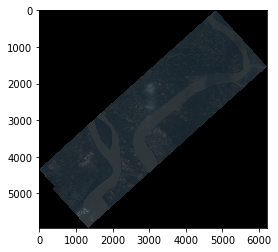

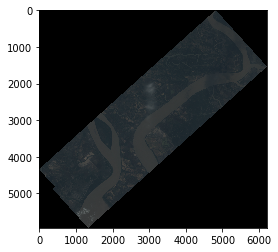

In [52]:
show_rgb(img_file)
show_rgb(toar_file)

The effect of conversion to reflectance isn't really apparent in one image. But when comparing two images taken at different times of the year, the conversion to reflectance will remove effects of the sun's location and make the images more similar.

### Combined Tools - Clip and Band Math

This toolchain demonstrates how we can combine the clipping tool with the NDVI band math tool to only process and download the NDVI values for pixels we are interested in. Combining tools is as simple as combining the tool definitions in a list in the order request.

In [74]:
clip_bandmath_request = {
  "name": "clip and bandmath",
  "products": products,
  "tools": [clip, bandmath]
}
clip_bandmath_request

{'name': 'clip and bandmath',
 'products': [{'item_ids': ['20151119_025740_0c74'],
   'item_type': 'PSScene4Band',
   'product_bundle': 'analytic'}],
 'tools': [{'clip': {'aoi': {'coordinates': [[[94.81858044862747,
        15.858073043526062],
       [94.86242249608041, 15.858073043526062],
       [94.86242249608041, 15.894323164978303],
       [94.81858044862747, 15.894323164978303],
       [94.81858044862747, 15.858073043526062]]],
     'type': 'Polygon'}}},
  {'bandmath': {'b1': '(b4 - b3) / (b4 + b3)', 'pixel_type': '32R'}}]}

In [82]:
run_clip_bandmath = True

clip_bandmath_file = 'data/d1a94528-c1c3-4fe2-b3e5-6ff0c340a1d6/1/files/20151119_025740_0c74_3B_AnalyticMS_clip_bandmath.tif'
if os.path.isfile(clip_bandmath_file): run_clip_bandmath = False

In [83]:
if run_clip_bandmath:
    clip_bandmath_order_url = place_order(clip_bandmath_request, auth)
    poll_for_success(clip_bandmath_order_url, auth)
    downloaded_clip_bandmath_files = download_order(clip_bandmath_order_url, auth)
    clip_bandmath_file = next(downloaded_clip_bandmath_files[d] for d in downloaded_clip_bandmath_files
                     if d.endswith('_clip_bandmath.tif'))
clip_bandmath_file

'data/d1a94528-c1c3-4fe2-b3e5-6ff0c340a1d6/1/files/20151119_025740_0c74_3B_AnalyticMS_clip_bandmath.tif'

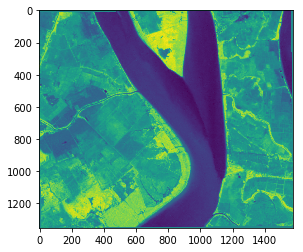

In [84]:
show_gray(clip_bandmath_file)

It is easy to add tools into a toolchain and saves a 'ton' of unnecessary pixel downloads and processing on our end. Big win!

## TOAR, Reproject, Tile

For a more complicated example, we will convert the pixels to reflectance, project them to WGS84, and then tile them.

In [87]:
reproject =     {
    "reproject": {
        "projection": "WGS84",
        "kernel": "cubic"
    }
}

tile = {
  "tile": {
    "tile_size": 1232,
    "origin_x": -180,
    "origin_y": -90,
    "pixel_size": 0.000027056277056,
    "name_template": "C1232_30_30_{tilex:04d}_{tiley:04d}"
  }
}

In [88]:
trt_request = {
  "name": "toar reproject tile",
  "products": products,
  "tools": [toar, reproject, tile]
}
trt_request

{'name': 'toar reproject tile',
 'products': [{'item_ids': ['20151119_025740_0c74'],
   'item_type': 'PSScene4Band',
   'product_bundle': 'analytic'}],
 'tools': [{'toar': {'scale_factor': 10000}},
  {'reproject': {'kernel': 'cubic', 'projection': 'WGS84'}},
  {'tile': {'name_template': 'C1232_30_30_{tilex:04d}_{tiley:04d}',
    'origin_x': -180,
    'origin_y': -90,
    'pixel_size': 2.7056277056e-05,
    'tile_size': 1232}}]}

In [90]:
run_trt = True

In [104]:
if run_trt:
    trt_order_url = place_order(trt_request, auth)
    poll_for_success(trt_order_url, auth)
    downloaded_trt_files = download_order(trt_order_url, auth)
    tile_files = list(d for d in downloaded_trt_files.values()
                     if d.name.startswith('C1232_30_30_'))
tile_files

[PosixPath('data/be824070-84b7-47dd-8d01-f00d7aa856af/1/files/C1232_30_30_8247_3178.tif'),
 PosixPath('data/be824070-84b7-47dd-8d01-f00d7aa856af/1/files/C1232_30_30_8242_3175.tif'),
 PosixPath('data/be824070-84b7-47dd-8d01-f00d7aa856af/1/files/C1232_30_30_8242_3176.tif'),
 PosixPath('data/be824070-84b7-47dd-8d01-f00d7aa856af/1/files/C1232_30_30_8243_3174.tif'),
 PosixPath('data/be824070-84b7-47dd-8d01-f00d7aa856af/1/files/C1232_30_30_8243_3176.tif'),
 PosixPath('data/be824070-84b7-47dd-8d01-f00d7aa856af/1/files/C1232_30_30_8243_3175.tif'),
 PosixPath('data/be824070-84b7-47dd-8d01-f00d7aa856af/1/files/C1232_30_30_8247_3177.tif'),
 PosixPath('data/be824070-84b7-47dd-8d01-f00d7aa856af/1/files/C1232_30_30_8245_3175.tif'),
 PosixPath('data/be824070-84b7-47dd-8d01-f00d7aa856af/1/files/C1232_30_30_8244_3176.tif'),
 PosixPath('data/be824070-84b7-47dd-8d01-f00d7aa856af/1/files/C1232_30_30_8245_3176.tif'),
 PosixPath('data/be824070-84b7-47dd-8d01-f00d7aa856af/1/files/C1232_30_30_8244_3175.tif'),

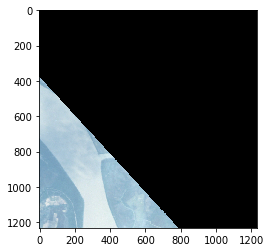

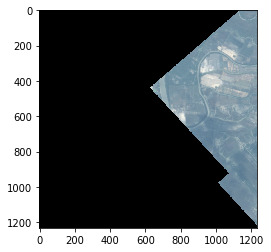

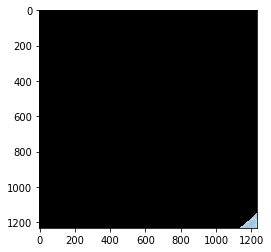

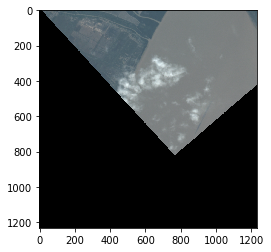

In [107]:
for f in tile_files[:4]:
    show_rgb(f)

In [114]:
test_file = tile_files[0]._str

In [121]:
!gdalinfo $test_file

Driver: GTiff/GeoTIFF
Files: data/be824070-84b7-47dd-8d01-f00d7aa856af/1/files/C1232_30_30_8247_3178.tif
Size is 1232, 1232
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (94.937826239999993,15.981247679999996)
Pixel Size = (0.000027060000000,-0.000027060000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (  94.9378262,  15.9812477) ( 94d56'16.17"E, 15d58'52.49"N)
Lower Left  (  94.9378262,  15.9479098) ( 94d56'16.17"E, 15d56'52.48"N)
Upper Right (  94.9711642,  15.9812477) ( 94d58'16.19"E, 15d58'52.49"N)
Lower Right (  94.9711642,  15.9479098) ( 94d58'16.19"E, 15d56'52.48"N)
Center      (  94.9544952,  15.9645787) ( 94d57'16.18"E, 15d57'52.48"N)
Band 1 Block=1232x1 T

The files have indeed been reprojected to WSG 84 and tiled. It is that easy!